In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import requests
import re

import networkx as nx

import warnings
warnings.filterwarnings("ignore")

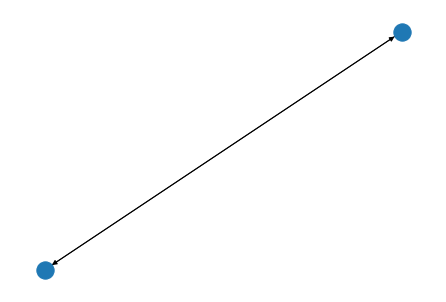

In [47]:
G = nx.MultiDiGraph()
G.add_edges_from([("one", "two"), ("two", "one")])

nx.draw(G)
plt.show()

In [97]:
class GraphCreator:
    
    def __init__(self, entry):
        self.graph = nx.MultiDiGraph()
        
        self.next_links = self.get_article_info(entry)['links']
        self.seen = {entry}
        
    def has_key(self, key, resp, pageid):
        return bool(resp['query']["pages"][pageid].get(key))
    
    def add_edges(self, article_info):
        self.graph.add_edges_from([(article_info['title'], link) for link in article_info['links']])
        self.graph.add_edges_from([(linkhere, article_info['title']) for linkhere in article_info['linkshere']])
        
    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()
    
    def get_degrees(self):
        return sorted([(key, val) for key, val in dict(self.graph.degree()).items()], key=lambda x: x[1], reverse=True)
    
    def expand_network(self):
        num_links = len(self.next_links)
        for i in range(num_links):
            link = self.next_links.pop()
            if not link in self.seen:
                self.seen.add(link)
                self.next_links += self.get_article_info(link)
    
    def get_article_info(self, title, generate_graph=True):
        params = {
            "action": "query",
            "format": "json",

            "titles": title,

            "prop": "extracts|redirects|links|linkshere|categories",

            # extracts
            "exintro": True,
            "explaintext": True,
            "exsectionformat": "plain",

            # redirects
            "rdnamespace": 0,
            "rdlimit": "max", 
            
            # links
            "pllimit": "max",
            "plnamespace": 0,

            # linkshere
            "lhlimit": "max",
            "lhnamespace": 0,
            "lhshow": "!redirect",

            # categories
            "cllimit": "max",
            
            # automatic redirect
            "redirects": 1
        }

        article_id = []
        extract = []
        redirects = []
        links = []
        linkshere = []
        categories = []

        def query_info(title, params):

            resp = requests.get(
                url="https://en.wikipedia.org/w/api.php",
                params=params).json()
            
#             pdb.set_trace()
            
            pageid = list(resp["query"]['pages'].keys())[0]
            
            article_id.append(pageid)
            
            if self.has_key("extract", resp, pageid):
                extract.append(resp['query']["pages"][pageid]['extract'])
            
            if self.has_key("redirects", resp, pageid):
                for rd in resp['query']["pages"][pageid]["redirects"]:
                    redirects.append(rd["title"])
                    
            if self.has_key("links", resp, pageid):
                for link in resp['query']["pages"][pageid]["links"]:
                    links.append(link["title"])

            if self.has_key("linkshere", resp, pageid):
                for lh in resp['query']["pages"][pageid]["linkshere"]:
                    linkshere.append(lh["title"])

            if self.has_key("categories", resp, pageid):
                for cat in resp['query']["pages"][pageid]["categories"]:
                    if not bool(re.findall(r"(articles)|(uses)|(commons)", cat["title"], re.I)):
                        categories.append(cat["title"])

            if resp.get('continue'):
                params.update(resp.get("continue"))
                query_info(title, params)

        query_info(title, params)
        
        article_info = {
            "pageid": int(article_id[0]),
            "title": title,
            "extract": extract,
            "redirects": redirects,
            "links": links,
            "linkshere": linkshere,
            "categories": categories,
        }
        
        if generate_graph:
            self.add_edges(article_info)
        
        return article_info

## TESTS

In [98]:
gc = GraphCreator("Random Forest")
gc.next_links = gc.next_links
gc.expand_network()

In [99]:
len(list(gc.graph.nodes))

8416

In [100]:
gc.get_degrees()

[('Wikipedia', 3629),
 ('Trademark', 2546),
 ('title', 1873),
 ('Unsupervised learning', 479),
 ('Support-vector machine', 332),
 ('Random Forest', 292),
 ('Temporal difference learning', 254),
 ('Vapnik–Chervonenkis theory', 251),
 ('T-distributed stochastic neighbor embedding', 244),
 ('extract', 228),
 ('U-Net', 223),
 ('links', 83),
 ('Trevor Hastie', 78),
 ('categories', 49),
 ('Test set', 38),
 ('Tin Kam Ho', 26),
 ('Machine learning', 19),
 ('Data mining', 17),
 ('Random forest', 17),
 ('Statistical classification', 16),
 ('Expectation–maximization algorithm', 15),
 ('Hierarchical clustering', 15),
 ('List of datasets for machine-learning research', 15),
 ('Naive Bayes classifier', 15),
 ('Outline of machine learning', 15),
 ('Statistical learning theory', 15),
 ('Supervised learning', 15),
 ('Anomaly detection', 14),
 ('Artificial neural network', 14),
 ('Association rule learning', 14),
 ('Autoencoder', 14),
 ('Automated machine learning', 14),
 ('BIRCH', 14),
 ('Boosting (mac